## A unified machine learning framework developed to predict tunnel boring machine (TBM) penetration rate (PRnet) using operational and geological parameters from a cross-project database, enabling comparative analysis of models including XGBoost, Random Forest, Bagging, Stacking, and Artificial Neural Network (ANN) approaches.

## Common setup: Importing Required Libraries, Data loading,  label encoding, feature scaling,

In [3]:
# =========================================================
# COMMON SETUP
# =========================================================
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Features and target
features = ['CRS', 'Thrust', 'Torque', 'RMR', 'PRchd', 'Weathering', 'Rock Strength']
target = 'PRnet'

# -----------------------
# Utility Functions
# -----------------------
def load_data(sheet_name):
    """Load Excel sheet as DataFrame."""
    return pd.read_excel('data for both case - Copy.xlsx', sheet_name=sheet_name)

def prepare_features(df, label_encoders=None, scaler=None, fit_encoders=False, fit_scaler=False):
    """Encode categorical features, scale features, return X_scaled, Y, encoders, scaler."""
    X = df[features].copy()
    Y = df[target]

    if label_encoders is None:
        label_encoders = {}

    for col in ['Weathering', 'Rock Strength']:
        if fit_encoders or col not in label_encoders:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            label_encoders[col] = le
        else:
            le = label_encoders[col]
            X[col] = X[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
            unknowns = (X[col] == -1).sum()
            if unknowns > 0:
                print(f"⚠️ {unknowns} unseen categories in '{col}' encoded as -1.")

    if scaler is None:
        scaler = RobustScaler()

    if fit_scaler:
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    return X_scaled, Y, label_encoders, scaler

## 1. XGBoost- model with different scenario

In [5]:
## Importing Required Libraries
from xgboost import XGBRegressor

# =========================================================
# XGBOOST MODEL BUILDER
# =========================================================

def train_xgb_model(X_train, Y_train):
    """Create and train XGBRegressor."""
    model = XGBRegressor(
        colsample_bytree=1, gamma=5, learning_rate=0.1,
        max_depth=7, n_estimators=100, subsample=0.8, random_state=42
    )
    model.fit(X_train, Y_train)
    return model

def evaluate_model(Y_true, Y_pred):
    """Compute metrics and round to three decimals."""
    r2 = r2_score(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mape = np.mean(np.abs((Y_true - Y_pred) / (Y_true + 1e-10))) * 100
    return {'R2': round(r2,3), 'MAE': round(mae,3), 'RMSE': round(rmse,3), 'MAPE': round(mape,3)}

# ================================
# INDIVIDUAL CASES
# ================================

# -----------------------
# Case A: Train & Test on BBDMP
# -----------------------
print("\n" + "="*40 + " Train & Test on BBDM Project Database " + "="*40)
df = load_data('BBDMP')
X_scaled, Y, label_encoders, scaler = prepare_features(df, fit_encoders=True, fit_scaler=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
model = train_xgb_model(X_train, Y_train)

train_metrics = evaluate_model(Y_train, model.predict(X_train))
test_metrics  = evaluate_model(Y_test, model.predict(X_test))

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)


# -----------------------
# Case B: Train on BBDMP, Test on SMDMP_Siwalik
# -----------------------
print("\n" + "="*40 + " Scenario 1: Train on BBDMP, Test on SMDMP_Siwalik " + "="*40)
df_train = load_data('BBDMP')
df_test  = load_data('SMDMP_Siwalik')

X_train, Y_train, label_encoders, scaler = prepare_features(df_train, fit_encoders=True, fit_scaler=True)
model = train_xgb_model(X_train, Y_train)
train_metrics = evaluate_model(Y_train, model.predict(X_train))

X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
test_metrics  = evaluate_model(Y_test, model.predict(X_test))

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)


# -----------------------
# Case C: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser
# -----------------------
print("\n" + "="*40 + " Scenario 2: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP_Siwalik')
df_test = load_data('SMDMP_Lesser')

X_train, Y_train, label_encoders, scaler = prepare_features(pd.concat([df1, df2]), fit_encoders=True, fit_scaler=True)
model = train_xgb_model(X_train, Y_train)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    Y_tr, Y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    model.fit(X_tr, Y_tr)
    Y_val_pred = model.predict(X_val)

    metrics = evaluate_model(Y_val, Y_val_pred)
    cv_results.append(metrics)

cv_df = pd.DataFrame(cv_results)
print("5-Fold Shuffle CV Metrics (Train):")
print(cv_df)
print("\nAverage CV Metrics (Train):")
print(cv_df.mean().round(3))

# Test set evaluation
X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
Y_test_pred = model.predict(X_test)
test_metrics = evaluate_model(Y_test, Y_test_pred)

print("\nTest Set Metrics (SMDMP_Lesser):")
print(test_metrics)

# -----------------------
# Case D: Train & Test on BBDMP + SMDMP
# -----------------------
print("\n" + "="*40 + " Scenario 3: Train & Test on BBDMP+SMDMP " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP')
df_combined = pd.concat([df1, df2])

X_scaled, Y, label_encoders, scaler = prepare_features(df_combined, fit_encoders=True, fit_scaler=True)
X_trainval, X_final_test, Y_trainval, Y_final_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_train_metrics = []
cv_val_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
    Y_tr, Y_val = Y_trainval.iloc[train_idx], Y_trainval.iloc[val_idx]

    model = train_xgb_model(X_tr, Y_tr)  # fresh model each fold

    # Predictions
    Y_tr_pred = model.predict(X_tr)
    Y_val_pred = model.predict(X_val)

    # Evaluate both train & validation
    train_metrics = evaluate_model(Y_tr, Y_tr_pred)
    val_metrics   = evaluate_model(Y_val, Y_val_pred)

    cv_train_metrics.append(train_metrics)
    cv_val_metrics.append(val_metrics)

# Convert to DataFrames
train_df = pd.DataFrame(cv_train_metrics)
val_df   = pd.DataFrame(cv_val_metrics)

print("\n🔁 5-Fold CV Metrics (Training):")
print(train_df)
print("\n📊 Average Training Metrics:")
print(train_df.mean().round(3))

print("\n🔁 5-Fold CV Metrics (Validation):")
print(val_df)
print("\n📊 Average Validation Metrics:")
print(val_df.mean().round(3))

# Final Test set evaluation
model = train_xgb_model(X_trainval, Y_trainval)
Y_final_pred = model.predict(X_final_test)
final_test_metrics = evaluate_model(Y_final_test, Y_final_pred)
print("\nFinal Test Metrics (BBDMP+SMDMP):")
print(final_test_metrics)


======================================== Train & Test on BBDM Project Database ========================================
Train Metrics: {'R2': 0.97, 'MAE': 1.669, 'RMSE': 2.659, 'MAPE': 2.504}
Test Metrics:  {'R2': 0.937, 'MAE': 2.391, 'RMSE': 3.95, 'MAPE': 3.74}

======================================== Scenario 1: Train on BBDMP, Test on SMDMP_Siwalik ========================================
Train Metrics: {'R2': 0.968, 'MAE': 1.735, 'RMSE': 2.767, 'MAPE': 2.614}
Test Metrics:  {'R2': 0.78, 'MAE': 2.678, 'RMSE': 3.821, 'MAPE': 5.377}

======================================== Scenario 2: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser ========================================
5-Fold Shuffle CV Metrics (Train):
      R2    MAE   RMSE   MAPE
0  0.950  1.962  3.508  2.998
1  0.939  2.012  3.725  3.206
2  0.936  2.044  3.796  3.305
3  0.933  2.027  3.891  3.234
4  0.945  1.933  3.513  2.975

Average CV Metrics (Train):
R2      0.941
MAE     1.996
RMSE    3.687
MAPE    3.144
dtype: float

## Plot for 5-fold shuffle cross-validation results in XGBoost model

In [7]:
# ================================
# PLOT SCENARIO 3 RESULTS
# ================================
results_df = val_df.copy()
results_df['Fold'] = [f"Fold {i+1}" for i in range(len(results_df))]
x = np.arange(len(results_df['Fold']))
bar_width = 0.6

fig, ax1 = plt.subplots(figsize=(12, 8), dpi=800)

# -----------------------------
# Bar plot for R² (left y-axis)
# -----------------------------
bars = ax1.bar(x, results_df['R2'], width=bar_width, color='skyblue', label='R² Validation')
ax1.set_ylabel('R² Score', color='blue', fontsize=20)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Fold'], fontsize=20)

# Y-axis ticks and limits for R²
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.set_ylim([0, 1.05])

# Add R² annotations above bars
for i, r2 in enumerate(results_df['R2']):
    ax1.text(x[i], r2 + 0.02, f"{r2:.3f}", ha='center', va='bottom', fontsize=20, color='blue')

# -----------------------------
# Error metrics (right y-axis)
# -----------------------------
ax2 = ax1.twinx()
ax2.plot(x, results_df['MAE'], color='black', marker='o', label='MAE')
ax2.plot(x, results_df['MAPE'], color='green', marker='s', label='MAPE')
ax2.plot(x, results_df['RMSE'], color='red', marker='^', label='RMSE')
ax2.set_ylabel('Error Metrics (Validation)', fontsize=20)
ax2.tick_params(axis='y', labelsize=20)

# Dynamic scaling for error metrics
max_error = results_df[['MAE', 'RMSE', 'MAPE']].values.max()
ax2.set_ylim([0, max_error + 1])

# -----------------------------
# Legends & Layout
# -----------------------------
ax1.legend(loc='center left', bbox_to_anchor=(0.05, 0.20), fontsize=14)
ax2.legend(title='Validation Metrics', loc='center right', bbox_to_anchor=(0.95, 0.20), fontsize=20, title_fontsize=20)

plt.title("", fontsize=20)
plt.tight_layout()
plt.savefig('cross_validation_validation_metrics.png', dpi=800)
plt.show()

## Confidence interval results in XGBoost model

In [9]:
import scipy.stats as stats
# Confidence interval for R²
r2_scores = results_df['R2'].values
n = len(r2_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores, ddof=1)
sem_r2 = std_r2 / np.sqrt(n)
t_critical = stats.t.ppf(0.975, df=n-1)  # 95% CI
margin_of_error = t_critical * sem_r2
ci_lower = mean_r2 - margin_of_error
ci_upper = mean_r2 + margin_of_error

print(f"R² Mean: {mean_r2:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}] (±{margin_of_error:.4f})")

# Best fold
best_fold_idx = results_df['R2'].idxmax()
print(f"Best fold: {results_df.loc[best_fold_idx, 'Fold']} with R² = {results_df.loc[best_fold_idx, 'R2']:.3f}")

R² Mean: 0.9654
95% Confidence Interval: [0.9580, 0.9728] (±0.0074)
Best fold: Fold 3 with R² = 0.973


## SHAP_Model Interpretability Analysis

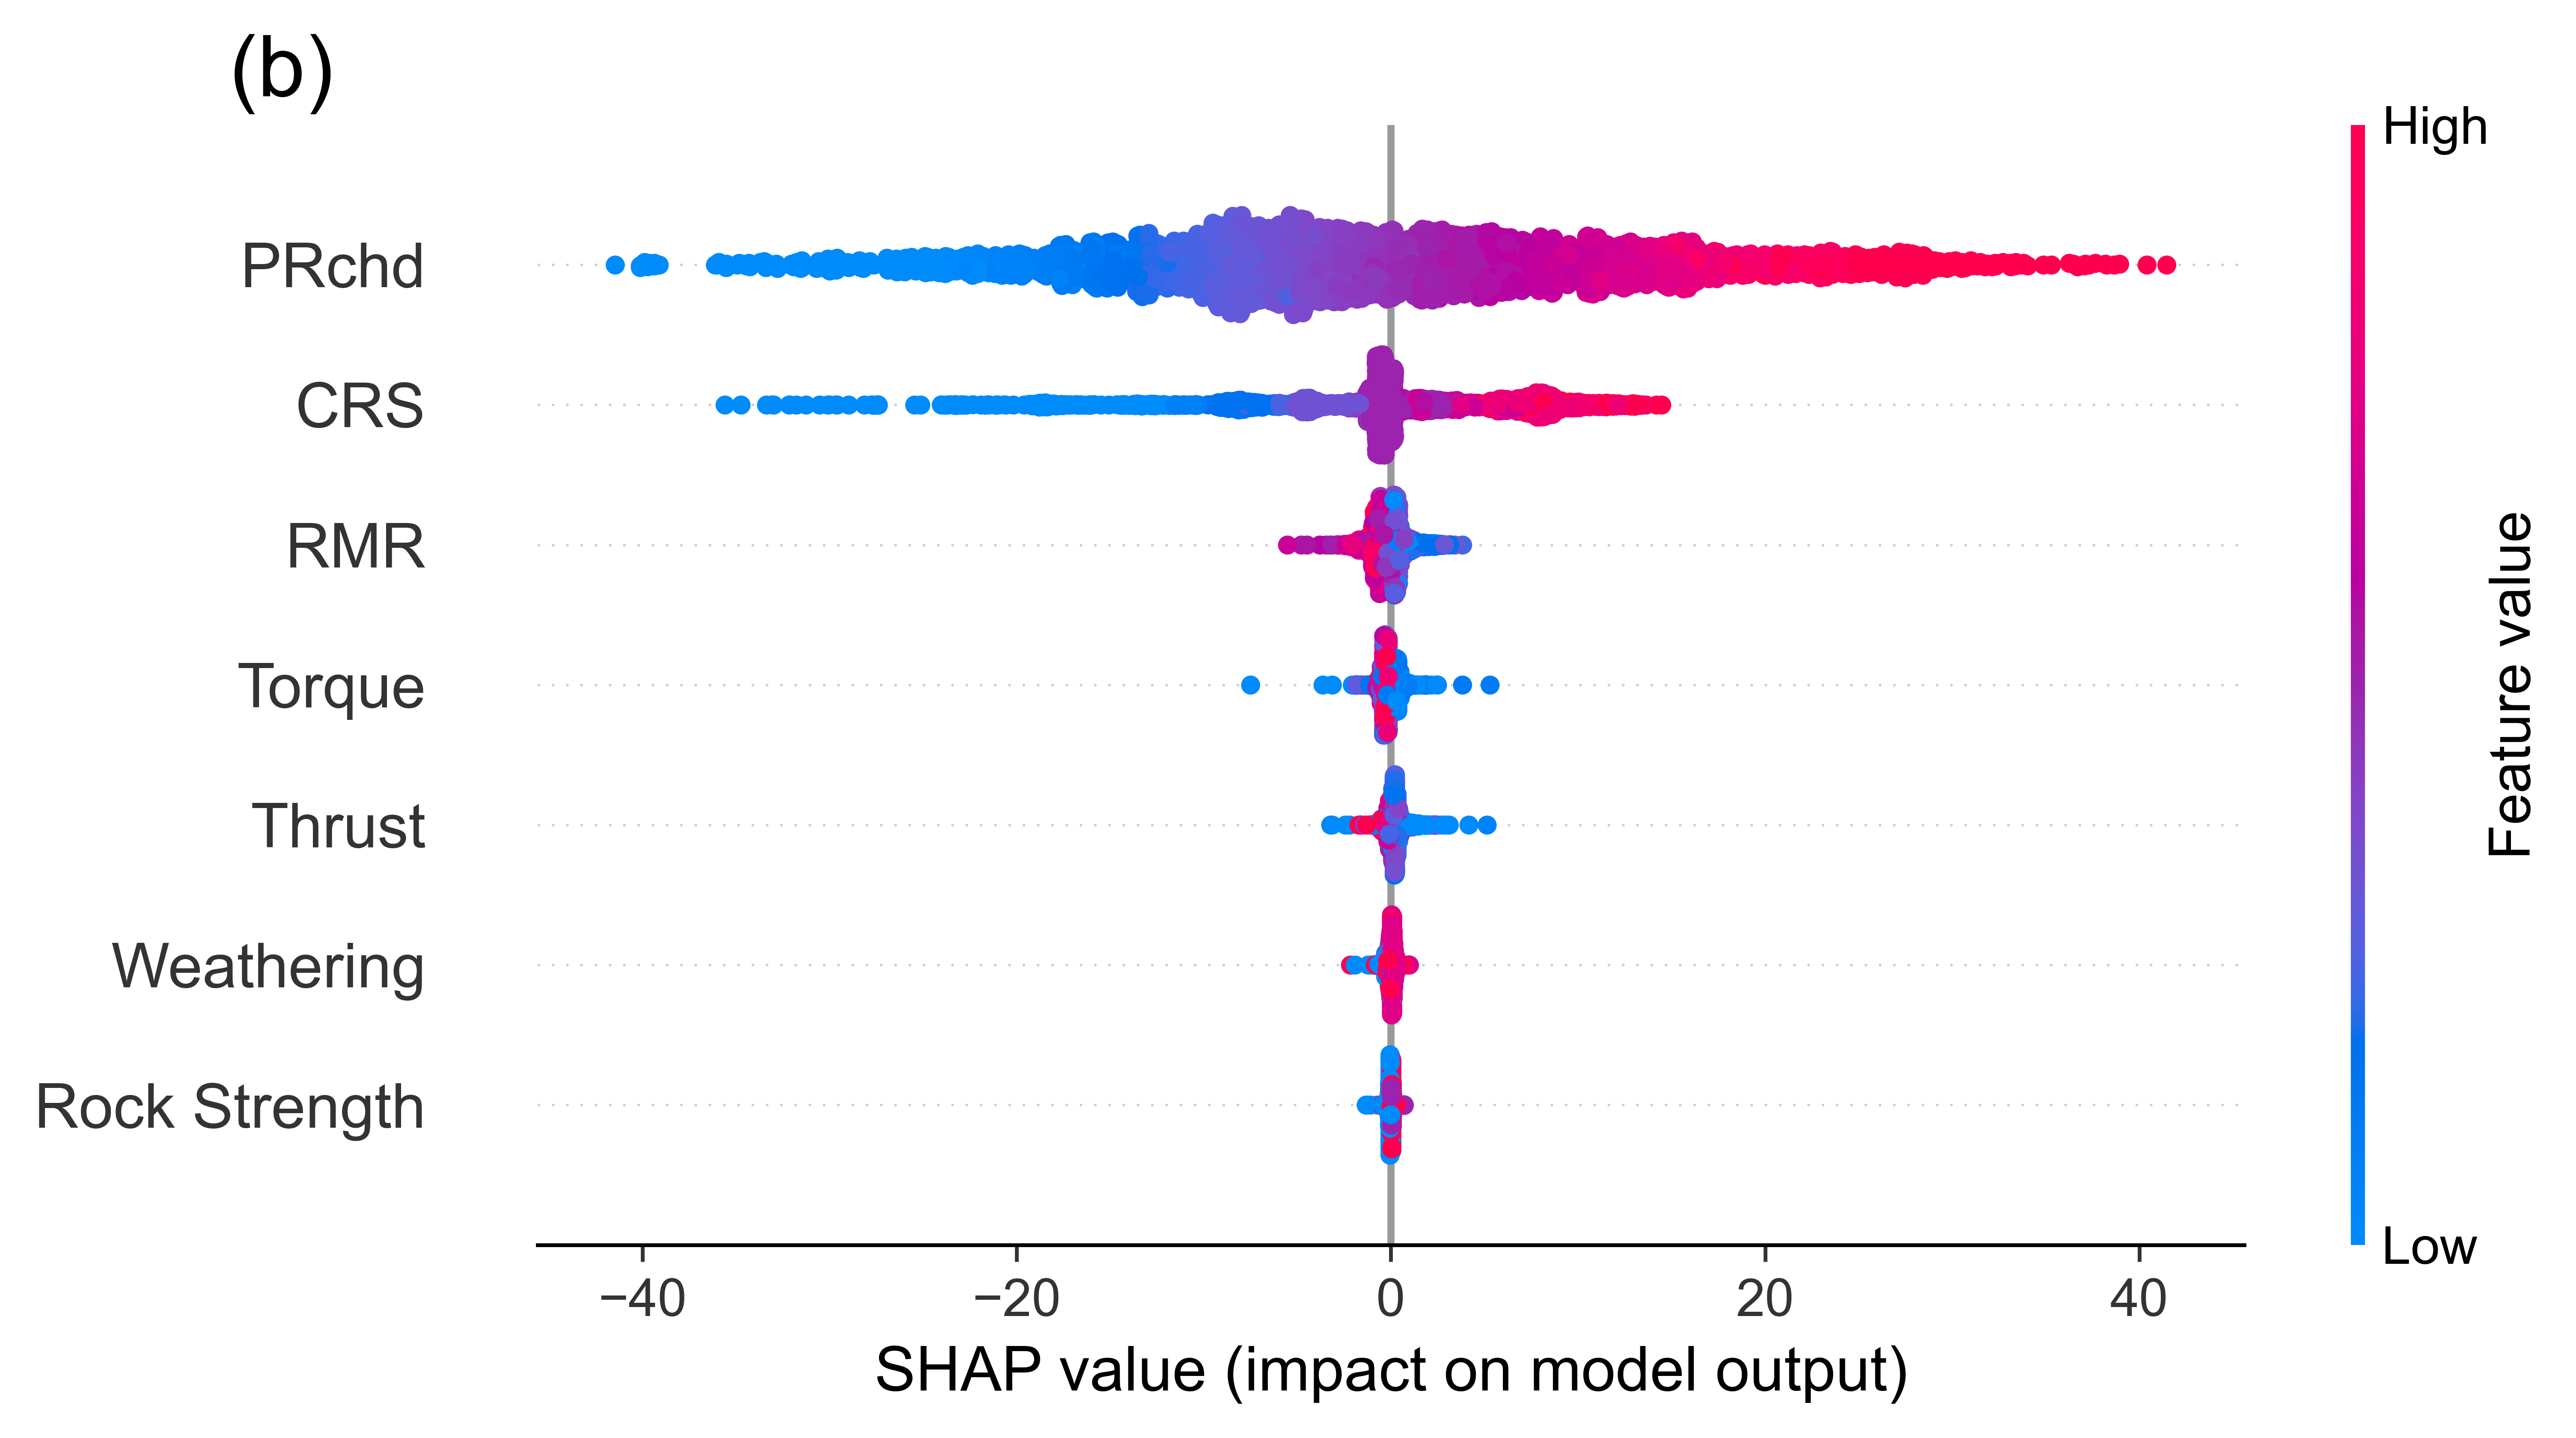

In [11]:
import shap

# Set default font
matplotlib.rcParams['font.family'] = 'Arial'

# Assign train/test
X_train_scaled = X_trainval
X_test_scaled = X_final_test

# Use the trained model
optimal_model = model

# SHAP explainer
explainer = shap.TreeExplainer(optimal_model)
shap_values = explainer(X_test_scaled)

# -------------------------
# Bar Plot: Mean SHAP Value
# -------------------------
mean_shap_values = np.mean(np.abs(shap_values.values), axis=0)
feature_names = features
feature_shap_pairs = sorted(zip(feature_names, mean_shap_values), key=lambda x: x[1], reverse=True)
sorted_features, avg_shap_values = zip(*feature_shap_pairs)

plt.figure(figsize=(10, 6), dpi=1200)
bars = plt.barh(sorted_features, avg_shap_values, color='skyblue')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center', ha='left', color='black', fontsize=16)

plt.xticks(fontsize=18, color='black')
plt.yticks(fontsize=18, color='black')
plt.xlabel('mean (|SHAP value|)', fontsize=18, color='black')
plt.title('(a)', x=-0.15, y=1, fontsize=22)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('1.Feature_importance_2nd_Journal.png', bbox_inches='tight', dpi=1200)
plt.show()

# -------------------------
# SHAP Summary Plot
# -------------------------
plt.figure(figsize=(6, 10), dpi=800)
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.title('(b)', x=-0.15, y=1, fontsize=18)
plt.tight_layout()
plt.savefig("1.shap_summary_plot.png", dpi=800, bbox_inches='tight')
plt.show()

## 2. Random Forest model with different scenario

In [13]:
# =========================================================
# RANDOM FOREST MODEL BUILDER
# =========================================================
from sklearn.ensemble import RandomForestRegressor

def train_rf_model(X_train, Y_train):
    """Create and train RandomForestRegressor."""
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=30,
        max_features='log2',
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42
    )
    model.fit(X_train, Y_train)
    return model

def evaluate_model(Y_true, Y_pred):
    """Compute metrics and round to three decimals."""
    r2 = r2_score(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mape = np.mean(np.abs((Y_true - Y_pred) / (Y_true + 1e-10))) * 100
    return {'R2': round(r2,3), 'MAE': round(mae,3), 'RMSE': round(rmse,3), 'MAPE': round(mape,3)}

# ================================
# INDIVIDUAL CASES
# ================================

# -----------------------
# Case A: Train & Test on BBDMP
# -----------------------
print("\n" + "="*40 + " Train & Test on BBDM Project Database " + "="*40)
df = load_data('BBDMP')
X_scaled, Y, label_encoders, scaler = prepare_features(df, fit_encoders=True, fit_scaler=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
model = train_rf_model(X_train, Y_train)

train_metrics = evaluate_model(Y_train, model.predict(X_train))
test_metrics  = evaluate_model(Y_test, model.predict(X_test))

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)

# -----------------------
# Case B: Train on BBDMP, Test on SMDMP_Siwalik
# -----------------------
print("\n" + "="*40 + " Scenario 1: Train on BBDMP, Test on SMDMP_Siwalik " + "="*40)
df_train = load_data('BBDMP')
df_test  = load_data('SMDMP_Siwalik')

X_train, Y_train, label_encoders, scaler = prepare_features(df_train, fit_encoders=True, fit_scaler=True)
model = train_rf_model(X_train, Y_train)
train_metrics = evaluate_model(Y_train, model.predict(X_train))

X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
test_metrics  = evaluate_model(Y_test, model.predict(X_test))

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)

# -----------------------
# Case C: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser
# -----------------------
print("\n" + "="*40 + " Scenario 2: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP_Siwalik')
df_test = load_data('SMDMP_Lesser')

X_train, Y_train, label_encoders, scaler = prepare_features(pd.concat([df1, df2]), fit_encoders=True, fit_scaler=True)
model = train_rf_model(X_train, Y_train)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    Y_tr, Y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    model.fit(X_tr, Y_tr)
    Y_val_pred = model.predict(X_val)
    metrics = evaluate_model(Y_val, Y_val_pred)
    cv_results.append(metrics)

cv_df = pd.DataFrame(cv_results)
print("5-Fold Shuffle CV Metrics (Train):")
print(cv_df)
print("\nAverage CV Metrics (Train):")
print(cv_df.mean().round(3))

# Test set evaluation
X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
Y_test_pred = model.predict(X_test)
test_metrics = evaluate_model(Y_test, Y_test_pred)
print("\nTest Set Metrics (SMDMP_Lesser):")
print(test_metrics)

# -----------------------
# Case D: Train & Test on BBDMP + SMDMP
# -----------------------
print("\n" + "="*40 + " Scenario 3: Train & Test on BBDMP+SMDMP " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP')
df_combined = pd.concat([df1, df2])

X_scaled, Y, label_encoders, scaler = prepare_features(df_combined, fit_encoders=True, fit_scaler=True)
X_trainval, X_final_test, Y_trainval, Y_final_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_train_metrics = []
cv_val_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
    Y_tr, Y_val = Y_trainval.iloc[train_idx], Y_trainval.iloc[val_idx]

    model = train_rf_model(X_tr, Y_tr)

    # Predictions
    Y_tr_pred = model.predict(X_tr)
    Y_val_pred = model.predict(X_val)

    # Evaluate both train & validation
    train_metrics = evaluate_model(Y_tr, Y_tr_pred)
    val_metrics   = evaluate_model(Y_val, Y_val_pred)

    cv_train_metrics.append(train_metrics)
    cv_val_metrics.append(val_metrics)

# Convert to DataFrames
train_df = pd.DataFrame(cv_train_metrics)
val_df   = pd.DataFrame(cv_val_metrics)

print("\n🔁 5-Fold CV Metrics (Training):")
print(train_df)
print("\n📊 Average Training Metrics:")
print(train_df.mean().round(3))

print("\n🔁 5-Fold CV Metrics (Validation):")
print(val_df)
print("\n📊 Average Validation Metrics:")
print(val_df.mean().round(3))

# Final Test set evaluation
model = train_rf_model(X_trainval, Y_trainval)
Y_final_pred = model.predict(X_final_test)
final_test_metrics = evaluate_model(Y_final_test, Y_final_pred)
print("\nFinal Test Metrics (BBDMP+SMDMP):")
print(final_test_metrics)


======================================== Train & Test on BBDM Project Database ========================================
Train Metrics: {'R2': 0.978, 'MAE': 1.404, 'RMSE': 2.309, 'MAPE': 2.189}
Test Metrics:  {'R2': 0.931, 'MAE': 2.502, 'RMSE': 4.117, 'MAPE': 3.925}

======================================== Scenario 1: Train on BBDMP, Test on SMDMP_Siwalik ========================================
Train Metrics: {'R2': 0.979, 'MAE': 1.359, 'RMSE': 2.264, 'MAPE': 2.112}
Test Metrics:  {'R2': 0.432, 'MAE': 4.955, 'RMSE': 6.132, 'MAPE': 9.297}

======================================== Scenario 2: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser ========================================
5-Fold Shuffle CV Metrics (Train):
      R2    MAE   RMSE   MAPE
0  0.946  2.185  3.648  3.464
1  0.935  2.200  3.840  3.622
2  0.935  2.212  3.830  3.661
3  0.932  2.160  3.902  3.532
4  0.940  2.153  3.667  3.448

Average CV Metrics (Train):
R2      0.938
MAE     2.182
RMSE    3.777
MAPE    3.545
dtype: f

## 3. Bagging model model with different scenario

In [25]:
# =========================================================
# BAGGING REGRESSOR MODEL BUILDER
# =========================================================
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

def train_bagging_model(X_train, Y_train):
    """Create and train BaggingRegressor."""
    model = BaggingRegressor(
        estimator=DecisionTreeRegressor(),
        n_estimators=100,
        max_samples=0.5,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=False,
        random_state=42
    )
    model.fit(X_train, Y_train)
    return model

def evaluate_model(Y_true, Y_pred):
    """Compute metrics and round to three decimals."""
    r2 = r2_score(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mape = np.mean(np.abs((Y_true - Y_pred) / (Y_true + 1e-10))) * 100
    return {'R2': round(r2,3), 'MAE': round(mae,3), 'RMSE': round(rmse,3), 'MAPE': round(mape,3)}

# ================================
# 2INDIVIDUAL CASES
# ================================

# -----------------------
# Case A: Train & Test on BBDMP
# -----------------------
print("\n" + "="*40 + " BAGGING: Train & Test on BBDMP " + "="*40)
df = load_data('BBDMP')
X_scaled, Y, label_encoders, scaler = prepare_features(df, fit_encoders=True, fit_scaler=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
model = train_bagging_model(X_train, Y_train)

train_metrics = evaluate_model(Y_train, model.predict(X_train))
test_metrics  = evaluate_model(Y_test, model.predict(X_test))

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)

# -----------------------
# Case B: Train on BBDMP, Test on SMDMP_Siwalik
# -----------------------
print("\n" + "="*40 + " BAGGING: Train on BBDMP, Test on SMDMP_Siwalik " + "="*40)
df_train = load_data('BBDMP')
df_test  = load_data('SMDMP_Siwalik')

X_train, Y_train, label_encoders, scaler = prepare_features(df_train, fit_encoders=True, fit_scaler=True)
model = train_bagging_model(X_train, Y_train)
train_metrics = evaluate_model(Y_train, model.predict(X_train))

X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
test_metrics = evaluate_model(Y_test, model.predict(X_test))

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)

# -----------------------
# Case C: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser
# -----------------------
print("\n" + "="*40 + " BAGGING: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP_Siwalik')
df_test = load_data('SMDMP_Lesser')

X_train, Y_train, label_encoders, scaler = prepare_features(pd.concat([df1, df2]), fit_encoders=True, fit_scaler=True)
model = train_bagging_model(X_train, Y_train)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    Y_tr, Y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    model.fit(X_tr, Y_tr)
    Y_val_pred = model.predict(X_val)
    metrics = evaluate_model(Y_val, Y_val_pred)
    cv_results.append(metrics)

cv_df = pd.DataFrame(cv_results)
print("5-Fold Shuffle CV Metrics (Train):")
print(cv_df)
print("\nAverage CV Metrics (Train):")
print(cv_df.mean().round(3))

# Test set evaluation
X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
Y_test_pred = model.predict(X_test)
test_metrics = evaluate_model(Y_test, Y_test_pred)
print("\nTest Set Metrics (SMDMP_Lesser):")
print(test_metrics)

# -----------------------
# Case D: Train & Test on BBDMP + SMDMP
# -----------------------
print("\n" + "="*40 + " BAGGING: Train & Test on BBDMP+SMDMP " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP')
df_combined = pd.concat([df1, df2])

X_scaled, Y, label_encoders, scaler = prepare_features(df_combined, fit_encoders=True, fit_scaler=True)
X_trainval, X_final_test, Y_trainval, Y_final_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_train_metrics = []
cv_val_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
    Y_tr, Y_val = Y_trainval.iloc[train_idx], Y_trainval.iloc[val_idx]

    model = train_bagging_model(X_tr, Y_tr)

    # Predictions
    Y_tr_pred = model.predict(X_tr)
    Y_val_pred = model.predict(X_val)

    # Evaluate both train & validation
    train_metrics = evaluate_model(Y_tr, Y_tr_pred)
    val_metrics   = evaluate_model(Y_val, Y_val_pred)

    cv_train_metrics.append(train_metrics)
    cv_val_metrics.append(val_metrics)

# Convert to DataFrames
train_df = pd.DataFrame(cv_train_metrics)
val_df   = pd.DataFrame(cv_val_metrics)

print("\n🔁 5-Fold CV Metrics (Training):")
print(train_df)
print("\n📊 Average Training Metrics:")
print(train_df.mean().round(3))

print("\n🔁 5-Fold CV Metrics (Validation):")
print(val_df)
print("\n📊 Average Validation Metrics:")
print(val_df.mean().round(3))

# Final Test set evaluation
model = train_bagging_model(X_trainval, Y_trainval)
Y_final_pred = model.predict(X_final_test)
final_test_metrics = evaluate_model(Y_final_test, Y_final_pred)
print("\nFinal Test Metrics (BBDMP+SMDMP):")
print(final_test_metrics)


======================================== BAGGING: Train & Test on BBDMP ========================================
Train Metrics: {'R2': 0.97, 'MAE': 1.501, 'RMSE': 2.666, 'MAPE': 2.315}
Test Metrics:  {'R2': 0.935, 'MAE': 2.348, 'RMSE': 3.995, 'MAPE': 3.675}

======================================== BAGGING: Train on BBDMP, Test on SMDMP_Siwalik ========================================
Train Metrics: {'R2': 0.972, 'MAE': 1.464, 'RMSE': 2.602, 'MAPE': 2.251}
Test Metrics:  {'R2': 0.822, 'MAE': 2.551, 'RMSE': 3.437, 'MAPE': 4.967}

======================================== BAGGING: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser ========================================
5-Fold Shuffle CV Metrics (Train):
      R2    MAE   RMSE   MAPE
0  0.949  1.958  3.546  2.993
1  0.938  1.990  3.753  3.160
2  0.937  2.012  3.785  3.246
3  0.933  1.967  3.888  3.120
4  0.941  1.922  3.622  2.998

Average CV Metrics (Train):
R2      0.940
MAE     1.970
RMSE    3.719
MAPE    3.103
dtype: float64

Test S

## 4. Stacking  model with different scenario

In [31]:
# =========================================================
# STACKING ENSEMBLE MODEL BUILDER
# =========================================================
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

def train_stacking_model(X_train, Y_train):
    """Create and train Stacking Regressor."""
    
    # Base models
    base_models = [
        ('SVR', SVR(C=50.0, gamma='scale', kernel='rbf')),
        ('DT', DecisionTreeRegressor(
            criterion='absolute_error',
            max_depth=10, 
            min_samples_leaf=6, 
            min_samples_split=2, 
            splitter='best'
        )),
        ('RF', RandomForestRegressor(
            random_state=42, 
            max_depth=30, 
            max_features='log2', 
            min_samples_leaf=1, 
            min_samples_split=5, 
            n_estimators=200
        )),
        ('KNN', KNeighborsRegressor(
            n_neighbors=5, 
            p=1, 
            weights='distance',
            algorithm='auto'
        )),
        ('XGBoost', XGBRegressor(
            colsample_bytree=1,
            gamma=5, 
            learning_rate=0.1,
            max_depth=7,
            n_estimators=100, 
            subsample=0.8,
            random_state=42
        )),
        ('Bagging', BaggingRegressor(
            bootstrap=True, 
            bootstrap_features=False, 
            max_features=1.0,
            max_samples=0.5, 
            n_estimators=100,
            random_state=42
        ))
    ]
    
    # Meta-model
    meta_regressor = RandomForestRegressor(
        random_state=42, 
        max_depth=30, 
        max_features='sqrt', 
        min_samples_leaf=1,
        min_samples_split=5, 
        n_estimators=200
    )
    
    # Stacking regressor
    stacking_model = StackingRegressor(
        estimators=base_models, 
        final_estimator=meta_regressor,
        passthrough=False,
        n_jobs=-1
    )
    
    stacking_model.fit(X_train, Y_train)
    return stacking_model

def evaluate_model(Y_true, Y_pred):
    """Compute metrics and round to three decimals."""
    r2 = r2_score(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mape = np.mean(np.abs((Y_true - Y_pred) / (Y_true + 1e-10))) * 100
    return {'R2': round(r2,3), 'MAE': round(mae,3), 'RMSE': round(rmse,3), 'MAPE': round(mape,3)}

# ================================
# INDIVIDUAL CASES
# ================================

# -----------------------
# Case A: Train & Test on BBDMP
# -----------------------
print("\n" + "="*40 + " Stacking Ensemble: Train & Test on BBDMP " + "="*40)
df = load_data('BBDMP')
X_scaled, Y, label_encoders, scaler = prepare_features(df, fit_encoders=True, fit_scaler=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
model = train_stacking_model(X_train, Y_train)

train_metrics = evaluate_model(Y_train, model.predict(X_train))
test_metrics  = evaluate_model(Y_test, model.predict(X_test))

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)

# -----------------------
# Case B: Train on BBDMP, Test on SMDMP_Siwalik
# -----------------------
print("\n" + "="*40 + " Stacking Ensemble: Train on BBDMP, Test on SMDMP_Siwalik " + "="*40)
df_train = load_data('BBDMP')
df_test  = load_data('SMDMP_Siwalik')

X_train, Y_train, label_encoders, scaler = prepare_features(df_train, fit_encoders=True, fit_scaler=True)
model = train_stacking_model(X_train, Y_train)

X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
train_metrics = evaluate_model(Y_train, model.predict(X_train))
test_metrics  = evaluate_model(Y_test, model.predict(X_test))

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)

# -----------------------
# Case C: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser
# -----------------------
print("\n" + "="*40 + " Stacking Ensemble: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP_Siwalik')
df_test = load_data('SMDMP_Lesser')

X_train, Y_train, label_encoders, scaler = prepare_features(pd.concat([df1, df2]), fit_encoders=True, fit_scaler=True)
model = train_stacking_model(X_train, Y_train)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    Y_tr, Y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    fold_model = train_stacking_model(X_tr, Y_tr)
    Y_val_pred = fold_model.predict(X_val)
    metrics = evaluate_model(Y_val, Y_val_pred)
    cv_results.append(metrics)

cv_df = pd.DataFrame(cv_results)
print("5-Fold Shuffle CV Metrics (Train):")
print(cv_df)
print("\nAverage CV Metrics (Train):")
print(cv_df.mean().round(3))

# Test set evaluation
X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
Y_test_pred = model.predict(X_test)
test_metrics = evaluate_model(Y_test, Y_test_pred)
print("\nTest Set Metrics (SMDMP_Lesser):")
print(test_metrics)

# -----------------------
# Case D: Train & Test on BBDMP + SMDMP
# -----------------------
print("\n" + "="*40 + " Stacking Ensemble: Train & Test on BBDMP+SMDMP " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP')
df_combined = pd.concat([df1, df2])

X_scaled, Y, label_encoders, scaler = prepare_features(df_combined, fit_encoders=True, fit_scaler=True)
X_trainval, X_final_test, Y_trainval, Y_final_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_train_metrics = []
cv_val_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
    Y_tr, Y_val = Y_trainval.iloc[train_idx], Y_trainval.iloc[val_idx]

    fold_model = train_stacking_model(X_tr, Y_tr)
    Y_tr_pred = fold_model.predict(X_tr)
    Y_val_pred = fold_model.predict(X_val)

    train_metrics = evaluate_model(Y_tr, Y_tr_pred)
    val_metrics   = evaluate_model(Y_val, Y_val_pred)

    cv_train_metrics.append(train_metrics)
    cv_val_metrics.append(val_metrics)

# Convert to DataFrames
train_df = pd.DataFrame(cv_train_metrics)
val_df   = pd.DataFrame(cv_val_metrics)

print("\n🔁 5-Fold CV Metrics (Training):")
print(train_df)
print("\n📊 Average Training Metrics:")
print(train_df.mean().round(3))

print("\n🔁 5-Fold CV Metrics (Validation):")
print(val_df)
print("\n📊 Average Validation Metrics:")
print(val_df.mean().round(3))

# Final Test set evaluation
final_model = train_stacking_model(X_trainval, Y_trainval)
Y_final_pred = final_model.predict(X_final_test)
final_test_metrics = evaluate_model(Y_final_test, Y_final_pred)
print("\nFinal Test Metrics (BBDMP+SMDMP):")
print(final_test_metrics)


======================================== Stacking Ensemble: Train & Test on BBDMP ========================================
Train Metrics: {'R2': 0.973, 'MAE': 1.488, 'RMSE': 2.536, 'MAPE': 2.264}
Test Metrics:  {'R2': 0.937, 'MAE': 2.304, 'RMSE': 3.941, 'MAPE': 3.557}

======================================== Stacking Ensemble: Train on BBDMP, Test on SMDMP_Siwalik ========================================
Train Metrics: {'R2': 0.948, 'MAE': 2.047, 'RMSE': 3.542, 'MAPE': 3.142}
Test Metrics:  {'R2': 0.752, 'MAE': 3.117, 'RMSE': 4.051, 'MAPE': 5.975}

======================================== Stacking Ensemble: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser ========================================
5-Fold Shuffle CV Metrics (Train):
      R2    MAE   RMSE   MAPE
0  0.948  1.979  3.571  3.039
1  0.940  1.968  3.692  3.144
2  0.935  2.008  3.831  3.250
3  0.932  1.972  3.913  3.154
4  0.940  1.959  3.663  3.038

Average CV Metrics (Train):
R2      0.939
MAE     1.977
RMSE    3.734
MAPE 

## 5. Artificial Neural Newtork (ANN) model model with different scenario

In [33]:
# =========================================================
# ARTIFICIAL NEURAL NETWORK (ANN) MODEL BUILDER
# =========================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_optimal_model(input_dim):
    """Create and compile ANN model."""
    model = Sequential([
        Dense(units=352, activation='relu', kernel_initializer='glorot_uniform', input_shape=(input_dim,)),
        Dense(units=1, activation='relu', kernel_initializer='he_normal')
    ])
    adam_optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=adam_optimizer,
        loss='mean_absolute_error',
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    return model

def evaluate_model_ann(Y_true, Y_pred):
    """Compute metrics for ANN predictions and round to three decimals."""
    r2 = r2_score(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mape = np.mean(np.abs((Y_true - Y_pred) / (Y_true + 1e-10))) * 100
    return {'R2': round(r2,3), 'MAE': round(mae,3), 'RMSE': round(rmse,3), 'MAPE': round(mape,3)}

# ================================
# INDIVIDUAL CASES
# ================================

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# -----------------------
# Case A: Train & Test on BBDMP
# -----------------------
print("\n" + "="*40 + " ANN: Train & Test on BBDMP " + "="*40)
df = load_data('BBDMP')
X_scaled, Y, label_encoders, scaler = prepare_features(df, fit_encoders=True, fit_scaler=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

model = create_optimal_model(X_train.shape[1])
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

train_metrics = evaluate_model_ann(Y_train, model.predict(X_train).flatten())
test_metrics  = evaluate_model_ann(Y_test, model.predict(X_test).flatten())

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)

# -----------------------
# Case B: Train on BBDMP, Test on SMDMP_Siwalik
# -----------------------
print("\n" + "="*40 + " ANN: Train on BBDMP, Test on SMDMP_Siwalik " + "="*40)
df_train = load_data('BBDMP')
df_test  = load_data('SMDMP_Siwalik')

X_train, Y_train, label_encoders, scaler = prepare_features(df_train, fit_encoders=True, fit_scaler=True)
model = create_optimal_model(X_train.shape[1])
model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
train_metrics = evaluate_model_ann(Y_train, model.predict(X_train).flatten())
test_metrics  = evaluate_model_ann(Y_test, model.predict(X_test).flatten())

print("Train Metrics:", train_metrics)
print("Test Metrics: ", test_metrics)

# -----------------------
# Case C: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser
# -----------------------
print("\n" + "="*40 + " ANN: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP_Siwalik')
df_test = load_data('SMDMP_Lesser')

X_train, Y_train, label_encoders, scaler = prepare_features(pd.concat([df1, df2]), fit_encoders=True, fit_scaler=True)
model = create_optimal_model(X_train.shape[1])
model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    Y_tr, Y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    fold_model = create_optimal_model(X_tr.shape[1])
    fold_model.fit(X_tr, Y_tr, validation_data=(X_val,Y_val), epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

    Y_val_pred = fold_model.predict(X_val).flatten()
    metrics = evaluate_model_ann(Y_val, Y_val_pred)
    cv_results.append(metrics)

cv_df = pd.DataFrame(cv_results)
print("5-Fold Shuffle CV Metrics (Train):")
print(cv_df)
print("\nAverage CV Metrics (Train):")
print(cv_df.mean().round(3))

# Test set evaluation
X_test, Y_test, _, _ = prepare_features(df_test, label_encoders=label_encoders, scaler=scaler)
Y_test_pred = model.predict(X_test).flatten()
test_metrics = evaluate_model_ann(Y_test, Y_test_pred)
print("\nTest Set Metrics (SMDMP_Lesser):")
print(test_metrics)

# -----------------------
# Case D: Train & Test on BBDMP + SMDMP
# -----------------------
print("\n" + "="*40 + " ANN: Train & Test on BBDMP+SMDMP " + "="*40)
df1 = load_data('BBDMP')
df2 = load_data('SMDMP')
df_combined = pd.concat([df1, df2])

X_scaled, Y, label_encoders, scaler = prepare_features(df_combined, fit_encoders=True, fit_scaler=True)
X_trainval, X_final_test, Y_trainval, Y_final_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_train_metrics = []
cv_val_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
    Y_tr, Y_val = Y_trainval.iloc[train_idx], Y_trainval.iloc[val_idx]

    fold_model = create_optimal_model(X_tr.shape[1])
    fold_model.fit(X_tr, Y_tr, validation_data=(X_val,Y_val), epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

    # Predictions
    Y_tr_pred = fold_model.predict(X_tr).flatten()
    Y_val_pred = fold_model.predict(X_val).flatten()

    # Evaluate both train & validation
    train_metrics = evaluate_model_ann(Y_tr, Y_tr_pred)
    val_metrics   = evaluate_model_ann(Y_val, Y_val_pred)

    cv_train_metrics.append(train_metrics)
    cv_val_metrics.append(val_metrics)

# Convert to DataFrames
train_df = pd.DataFrame(cv_train_metrics)
val_df   = pd.DataFrame(cv_val_metrics)

print("\n🔁 5-Fold CV Metrics (Training):")
print(train_df)
print("\n📊 Average Training Metrics:")
print(train_df.mean().round(3))

print("\n🔁 5-Fold CV Metrics (Validation):")
print(val_df)
print("\n📊 Average Validation Metrics:")
print(val_df.mean().round(3))

# Final Test set evaluation
final_model = create_optimal_model(X_trainval.shape[1])
final_model.fit(X_trainval, Y_trainval, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
Y_final_pred = final_model.predict(X_final_test).flatten()
final_test_metrics = evaluate_model_ann(Y_final_test, Y_final_pred)
print("\nFinal Test Metrics (BBDMP+SMDMP):")
print(final_test_metrics)


======================================== ANN: Train & Test on BBDMP ========================================
54/54 [==============================] - 0s 786us/step
Train Metrics: {'R2': 0.912, 'MAE': 2.262, 'RMSE': 4.577, 'MAPE': 3.457}
Test Metrics:  {'R2': 0.933, 'MAE': 2.212, 'RMSE': 4.082, 'MAPE': 3.441}

======================================== ANN: Train on BBDMP, Test on SMDMP_Siwalik ========================================
100/100 [==============================] - 0s 722us/step
Train Metrics: {'R2': 0.917, 'MAE': 2.177, 'RMSE': 4.482, 'MAPE': 3.341}
Test Metrics:  {'R2': -0.062, 'MAE': 6.03, 'RMSE': 8.386, 'MAPE': 12.206}

======================================== ANN: Train on BBDMP+SMDMP_Siwalik, Test on SMDMP_Lesser ========================================
74/74 [==============================] - 0s 790us/step
5-Fold Shuffle CV Metrics (Train):
      R2    MAE   RMSE   MAPE
0  0.944  1.783  3.732  2.721
1  0.933  1.835  3.908  2.933
2  0.931  1.784  3.955  2.818
3  0.927  